## Load data

In [0]:
from IPython.display import Image

In [0]:
from data import DatasetManager
import yaml

with open('file_cfg.yml') as f:
    cfg = yaml.load(f)

data = DatasetManager(cfg).get_data()
assert(list(data.keys()) == ['by_country', 'by_date'])

In [0]:
data['by_date'].set_index('country_code', inplace=True)
data['by_country'].set_index('country_code', inplace=True)

## Define model and data splits

In [0]:
from models.selection import model_per_country_simple_split
from models import CompartmentalOptimizer

optimizer = CompartmentalOptimizer(optim_days=14)

split = model_per_country_simple_split(
    data['by_date'],
    targets=['cases', 'deaths']
)

test_countries = True
if test_countries:
    split = [(x, y) for x, y in split if x in ['DEU', 'ITA']]

## Collect predictions

In [0]:
results = {}
country_population = data['by_country']['population']
for code, values in split:
    cases = values['cases']
    deaths = values['deaths']
    population = country_population.loc[code]
    res = optimizer.fit(cases, deaths, population)
    pred_cases, pred_ded = optimizer.predict(res.x, cases, deaths, population, 30)
    results[code] = {
        'score': res.fun,
        'parameters': res.x,
        'original_cases': cases,
        'original_deaths': deaths,
        'predicted_cases': [int(x) for x in pred_cases],
        'predicted_deaths': [int(x) for x in pred_ded]
    }

## View the SEIR model parameters

In [6]:
parameters = dict(
    zip(
        optimizer.states.keys(),
        results['DEU']['parameters']
    )
)
parameters

{'L': 58.335146304899254,
 'R_0': 3.94723472349614,
 'critical_fraction': 0.21037561327494111,
 'fatal_fraction': 0.6281003734734454,
 'k': 10.0,
 'mild_fraction': 0.6602293118645701,
 'time_critical': 4.242841763958479,
 'time_in_hospital': 5.242841763958479,
 'time_incubation': 5.8504315763142944,
 'time_infectious': 4.6034125143602695}

## Visualize

In [0]:
from visualization.seir import graph_SEIR, graph_Rt

In [0]:
code = 'DEU'
first_date = data['by_date'].loc[code].query('cases > 0')['date'][0]
res = results[code]

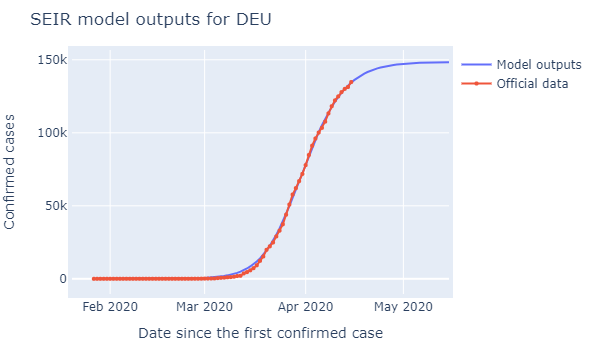

In [9]:
Image(filename='DEU-cases-SEIR.png')

In [10]:
graph_SEIR(code, res, first_date, data_key='cases')

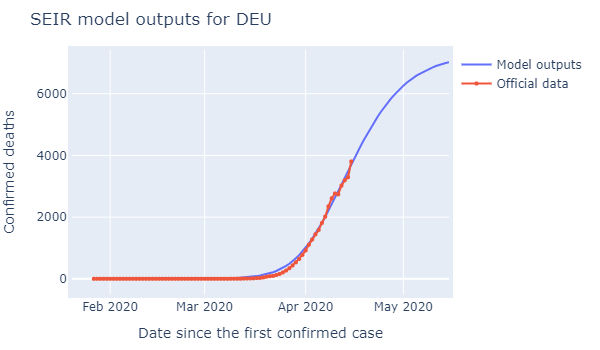

In [11]:
Image(filename='DEU-deaths-SEIR.png')

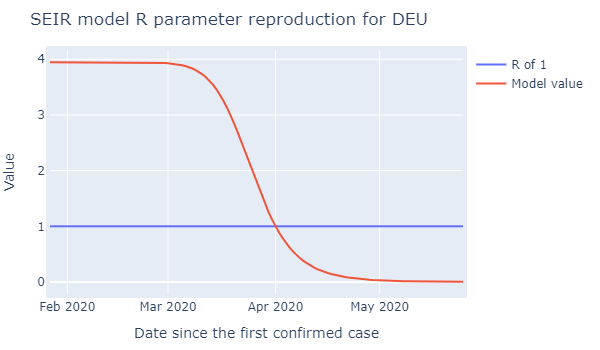

In [12]:
Image(filename='DEU-Rt-SEIR.png')

In [13]:
graph_SEIR(code, res, first_date, data_key='deaths')

In [14]:
graph_Rt(code, res, first_date, period=120)

In [0]:
code = 'ITA'
first_date = data['by_date'].loc[code].query('cases > 0')['date'][0]
res = results[code]

In [16]:
graph_SEIR(code, res, first_date, data_key='cases')